In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    @staticmethod
    def parse(inFile, flowDuration = 100):
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            packetLoss.append(packetLossInfo)
        return [(sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        _mapa = {
            "B": "#Bearer",
            "T": "TimeStamp",
            "TX": "Transmission",
            "RX": "Receiver",
            "D": "Delay",
            "ID": "#Packet",
            "DST": "Destiny",
            "SRC": "Source",
            "SIZE": "Size"
        }
        matches = re.findall("(TX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[_mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        _mapa = {
            "B": "#Bearer",
            "T": "TimeStamp",
            "TX": "Transmission",
            "RX": "Receiver",
            "D": "Delay",
            "ID": "#Packet",
            "DST": "Destiny",
            "SRC": "Source",
            "SIZE": "Size"
        }
        matches = re.findall("(RX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[_mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            tx_pkts += len(txContent[key])
        for key in rxContent:
            rx_pkts += len(rxContent[key])
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = delayPerApp[app]["Sum"]/tamanho if tamanho != 0 else 0
            delayPerApp[app]["StD"] = sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1) if tamanho != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"]/125000)/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"]/125000)/flowDuration
        return tputPerApp
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"]/125000)/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [3]:
base = "../raw_outputs/Interference_og"
ext = ".gz"
files = {1: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         2: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         3: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         4: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         5: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         6: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}}}
for sched in range(1,7):
    for ue in range(20, 101, 10):
        for vel in [30]:
            for count in range(1,6):
                file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_V_" + str(vel) +"_D_0.1_" + str(count)
                filename = base + "/" + str(sched) + "/UE" + str(ue) + "/V" + str(vel) + file + ext
                files[sched][vel][ue].append(filename)

In [ ]:
pprint(files)

# Proportional and Fair - 30KM/H

In [4]:
GPUTSVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
GPUTSVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PACKETLOSS = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    for ue in range(20, 101, 10):
        info = LTEParser.parse(files[sched][30][ue], 100)
        GPUTSVIDEO[sched].append(info[0])
        FAIRVIDEO[sched].append(info[1])
        DELAYVIDEO[sched].append(info[2])
        JITTERVIDEO[sched].append(info[3])
        GPUTSVOICE[sched].append(info[4])
        FAIRVOICE[sched].append(info[5])
        DELAYVOICE[sched].append(info[6])
        JITTERVOICE[sched].append(info[7])
        PACKETLOSS[sched].append(info[8])
    GPUTSVIDEO[sched] = np.array(GPUTSVIDEO[sched], dtype=np.float32)
    FAIRVIDEO[sched] = np.array(FAIRVIDEO[sched], dtype=np.float32)
    DELAYVIDEO[sched] = np.array(DELAYVIDEO[sched], dtype = np.float32)
    DELAYVOICE[sched] = np.array(DELAYVOICE[sched], dtype = np.float32)
    GPUTSVOICE[sched] = np.array(GPUTSVOICE[sched], dtype=np.float32)
    FAIRVOICE[sched] = np.array(FAIRVOICE[sched], dtype=np.float32)
    JITTERVIDEO[sched] = np.array(JITTERVIDEO[sched], dtype = np.float32)
    JITTERVIDEO[sched] = np.array(JITTERVOICE[sched], dtype = np.float32)
    PACKETLOSS[sched] = np.array(PACKETLOSS[sched], dtype=np.float32)

Opening file: ../raw_outputs/Interference_og/1/UE20/V30/SCHED_1_UE_20_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE20/V30/SCHED_1_UE_20_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE20/V30/SCHED_1_UE_20_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE20/V30/SCHED_1_UE_20_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE20/V30/SCHED_1_UE_20_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE30/V30/SCHED_1_UE_30_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE30/V30/SCHED_1_UE_30_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE30/V30/SCHED_1_UE_30_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/1/UE30/V30/SCHED_1_UE_30_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interfer

Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE80/V30/SCHED_2_UE_80_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE80/V30/SCHED_2_UE_80_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE80/V30/SCHED_2_UE_80_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE90/V30/SCHED_2_UE_90_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE90/V30/SCHED_2_UE_90_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE90/V30/SCHED_2_UE_90_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE90/V30/SCHED_2_UE_90_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE90/V30/SCHED_2_UE_90_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/2/UE100/V30/SCHED_2_UE_100_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: 

Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE50/V30/SCHED_4_UE_50_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE60/V30/SCHED_4_UE_60_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE60/V30/SCHED_4_UE_60_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE60/V30/SCHED_4_UE_60_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE60/V30/SCHED_4_UE_60_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE60/V30/SCHED_4_UE_60_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE70/V30/SCHED_4_UE_70_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE70/V30/SCHED_4_UE_70_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/4/UE70/V30/SCHED_4_UE_70_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ..

Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE30/V30/SCHED_6_UE_30_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE30/V30/SCHED_6_UE_30_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE30/V30/SCHED_6_UE_30_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE30/V30/SCHED_6_UE_30_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE40/V30/SCHED_6_UE_40_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE40/V30/SCHED_6_UE_40_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE40/V30/SCHED_6_UE_40_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE40/V30/SCHED_6_UE_40_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../raw_outputs/Interference_og/6/UE40/V30/SCHED_6_UE_40_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ..

# VIDEO GPUT MB/s

In [5]:
MEGAVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    MEGAVIDEO[sched] = np.true_divide(GPUTSVIDEO[sched], 8)
MEGAVIDEO

{1: array([2.2148826, 2.364355 , 2.0977623, 1.6342621, 1.5218714, 1.5134265,
        1.3793739, 1.2845742, 1.4390168], dtype=float32),
 2: array([2.3386433, 3.0370286, 3.5265777, 3.8687956, 4.007427 , 3.8043218,
        3.6177866, 3.637041 , 3.5646963], dtype=float32),
 3: array([2.3376777, 3.1050265, 3.4144003, 3.5860052, 3.6668544, 3.7282517,
        3.5658712, 3.5586884, 3.405538 ], dtype=float32),
 4: array([2.5662441, 3.8338766, 5.0958242, 6.2881975, 7.2418613, 8.827848 ,
        9.265413 , 9.164656 , 8.317621 ], dtype=float32),
 5: array([2.548457 , 3.7641788, 4.8183255, 5.395972 , 5.5598655, 5.008074 ,
        4.8029914, 4.5215826, 4.3137703], dtype=float32),
 6: array([2.3204558, 3.0319798, 3.5857835, 3.7184653, 3.9279306, 3.7181394,
        3.5940406, 3.6067681, 3.4143112], dtype=float32)}

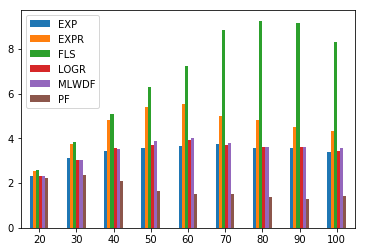

In [6]:
dfGPUTVIDEO = pd.DataFrame({'PF': MEGAVIDEO[1], 'MLWDF': MEGAVIDEO[2], 'EXP': MEGAVIDEO[3],
                       'FLS': MEGAVIDEO[4], 'EXPR': MEGAVIDEO[5], 'LOGR': MEGAVIDEO[6]},
                      index=[20,30,40,50,60,70,80,90,100])
dfGPUTVIDEO.plot.bar(rot=0)

In [7]:
dfGPUTVIDEO

,EXP,EXPR,FLS,LOGR,MLWDF,PF
20,2.337678,2.548457,2.566244,2.320456,2.338643,2.214883
30,3.105026,3.764179,3.833877,3.031980,3.037029,2.364355
40,3.414400,4.818326,5.095824,3.585783,3.526578,2.097762
50,3.586005,5.395972,6.288198,3.718465,3.868796,1.634262
60,3.666854,5.559865,7.241861,3.927931,4.007427,1.521871
70,3.728252,5.008074,8.827848,3.718139,3.804322,1.513427
80,3.565871,4.802991,9.265413,3.594041,3.617787,1.379374
90,3.558688,4.521583,9.164656,3.606768,3.637041,1.284574
100,3.405538,4.313770,8.317621,3.414311,3.564696,1.439017


# Delay Jitter

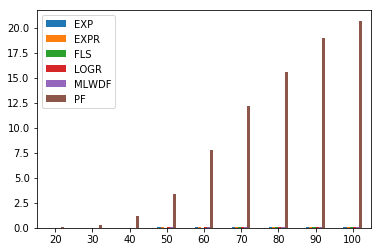

In [8]:
dfDELAYVIDEO = pd.DataFrame({'PF': DELAYVIDEO[1], 'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfDELAYVIDEO.plot.bar(rot=0)

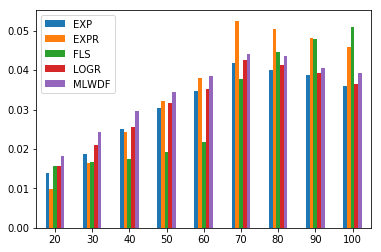

In [9]:
dfDELAYVIDEO = pd.DataFrame({'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfDELAYVIDEO.plot.bar(rot=0)

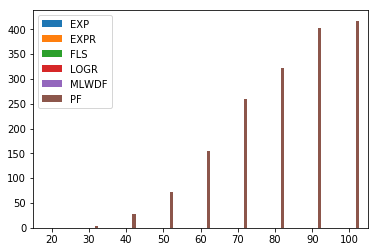

In [10]:
dfJITTERVIDEO = pd.DataFrame({'PF': JITTERVIDEO[1], 'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfJITTERVIDEO.plot.bar(rot=0)

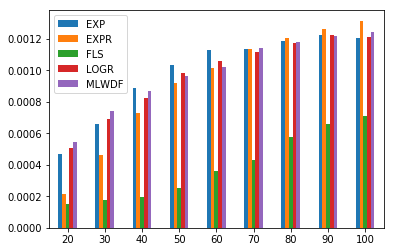

In [11]:
dfJITTERVIDEO = pd.DataFrame({'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfJITTERVIDEO.plot.bar(rot=0)

# VIDEO FAIRNESS

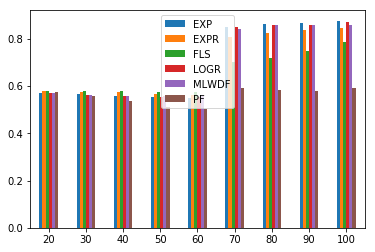

In [12]:
dfFAIRVIDEO = pd.DataFrame({'PF': FAIRVIDEO[1], 'MLWDF': FAIRVIDEO[2], 'EXP': FAIRVIDEO[3],
                            'FLS': FAIRVIDEO[4], 'EXPR': FAIRVIDEO[5], 'LOGR': FAIRVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfFAIRVIDEO.plot.bar(rot=0)

In [13]:
dfFAIRVIDEO

,EXP,EXPR,FLS,LOGR,MLWDF,PF
20,0.570829,0.577161,0.577705,0.570253,0.570991,0.572484
30,0.564085,0.575765,0.577319,0.562477,0.562990,0.558405
40,0.556576,0.572723,0.577021,0.559144,0.558671,0.537295
50,0.552306,0.566106,0.575912,0.553745,0.557846,0.510515
60,0.548183,0.561025,0.572519,0.551408,0.556765,0.501110
70,0.849181,0.805520,0.702755,0.849370,0.842329,0.590809
80,0.861192,0.822618,0.719932,0.858601,0.856404,0.582265
90,0.865470,0.835475,0.749332,0.859318,0.855772,0.580279
100,0.875930,0.846258,0.786680,0.871373,0.858159,0.590219


# VOIP GPUT MB/s

In [14]:
MEGAVOIP = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVOICE:
    MEGAVOIP[sched] = np.true_divide(GPUTSVOICE[sched], 8)
MEGAVOIP

{1: array([0.15050343, 0.22472449, 0.30163968, 0.37382194, 0.44339302,
        0.5222323 , 0.59225243, 0.6544343 , 0.7172521 ], dtype=float32),
 2: array([0.15181108, 0.22829312, 0.303722  , 0.38151014, 0.45109197,
        0.53241396, 0.5973581 , 0.6550077 , 0.7198075 ], dtype=float32),
 3: array([0.15331738, 0.2278656 , 0.30507112, 0.37914574, 0.44898713,
        0.51993805, 0.58499175, 0.65257573, 0.70902526], dtype=float32),
 4: array([0.1529938 , 0.22473882, 0.3078784 , 0.3819059 , 0.4606331 ,
        0.53279537, 0.61246103, 0.6792376 , 0.75851417], dtype=float32),
 5: array([0.1508306 , 0.23257805, 0.29933006, 0.3826007 , 0.45444146,
        0.532649  , 0.60579735, 0.6701978 , 0.7449057 ], dtype=float32),
 6: array([0.15272704, 0.22218394, 0.30298573, 0.37924814, 0.44685978,
        0.51720756, 0.5868544 , 0.6627988 , 0.7138473 ], dtype=float32)}

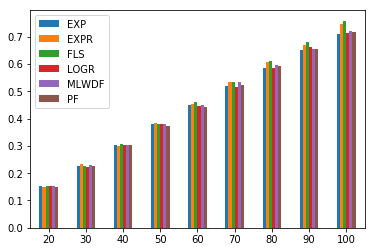

In [15]:
dfGPUTVOICE = pd.DataFrame({'PF': MEGAVOIP[1], 'MLWDF': MEGAVOIP[2], 'EXP': MEGAVOIP[3],
                       'FLS': MEGAVOIP[4], 'EXPR': MEGAVOIP[5], 'LOGR': MEGAVOIP[6]},
                      index=[20,30,40,50,60,70,80,90,100])
dfGPUTVOICE.plot.bar(rot=0)

In [16]:
dfGPUTVOICE

,EXP,EXPR,FLS,LOGR,MLWDF,PF
20,0.153317,0.150831,0.152994,0.152727,0.151811,0.150503
30,0.227866,0.232578,0.224739,0.222184,0.228293,0.224724
40,0.305071,0.299330,0.307878,0.302986,0.303722,0.301640
50,0.379146,0.382601,0.381906,0.379248,0.381510,0.373822
60,0.448987,0.454441,0.460633,0.446860,0.451092,0.443393
70,0.519938,0.532649,0.532795,0.517208,0.532414,0.522232
80,0.584992,0.605797,0.612461,0.586854,0.597358,0.592252
90,0.652576,0.670198,0.679238,0.662799,0.655008,0.654434
100,0.709025,0.744906,0.758514,0.713847,0.719808,0.717252


# Delay Jitter

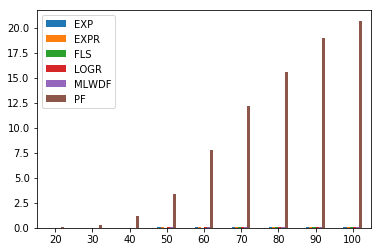

In [17]:
dfDELAYVOICE = pd.DataFrame({'PF': DELAYVOICE[1], 'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfDELAYVOICE.plot.bar(rot=0)

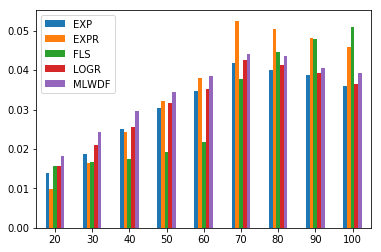

In [18]:
dfDELAYVOICE = pd.DataFrame({'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfDELAYVOICE.plot.bar(rot=0)

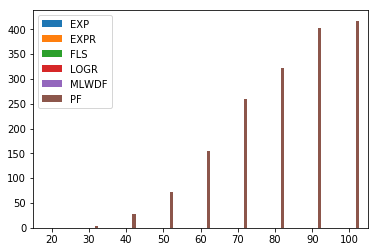

In [19]:
dfJITTERVOICE = pd.DataFrame({'PF': JITTERVOICE[1], 'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfJITTERVOICE.plot.bar(rot=0)

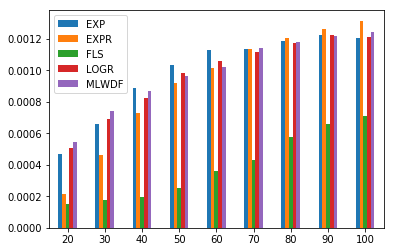

In [20]:
dfJITTERVOICE = pd.DataFrame({'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfJITTERVOICE.plot.bar(rot=0)

# Loss Ratio

In [21]:
averagePacketLoss = {}
for key in PACKETLOSS:
    averagePacketLoss[key] = []
    for i in range(0, 9):
        average = sum(PACKETLOSS[key][i])/len(PACKETLOSS[key][i])         
        averagePacketLoss[key].append(average)

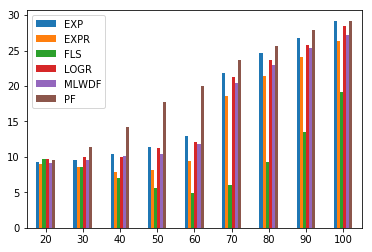

In [22]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1], 'MLWDF': averagePacketLoss[2], 'EXP': averagePacketLoss[3],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6]},
                           index=[20,30,40,50,60,70,80,90,100])
dfLossRatio.plot.bar(rot=0)

In [23]:
dfLossRatio

,EXP,EXPR,FLS,LOGR,MLWDF,PF
20,9.291710,9.013601,9.679068,9.648586,9.194442,9.611371
30,9.620909,8.608514,8.505981,10.024626,9.575970,11.383378
40,10.417503,7.857478,7.016857,10.008488,10.102857,14.175541
50,11.390495,8.169707,5.614501,11.296338,10.390390,17.699978
60,12.952917,9.360679,4.946942,12.150402,11.769320,20.029138
70,21.812537,18.576897,6.092966,21.234278,20.476736,23.602505
80,24.621591,21.426692,9.215624,23.727531,22.989555,25.614207
90,26.748894,24.073259,13.494854,25.761687,25.401390,27.833752
100,29.179362,26.401606,19.155427,28.428788,27.133649,29.207959
